In [1]:
import numpy as np
import trident
import yt
import os
import sys
from multiprocessing import Pool,current_process,cpu_count
import itertools
import logging

#import parse_vela_metadata
from sys import platform as _platform

yt.funcs.mylog.setLevel(50)

def convert_to_xyz(r, theta, phi):
    return np.array([r*np.sin(theta)*np.cos(phi),r*np.sin(theta)*np.sin(phi),r*np.cos(theta)])

def ray_endpoints_spherical(R,r,theta,phi,alpha,endonsph):
    start = convert_to_xyz(R,theta,phi)
    xhat = convert_to_xyz(1,np.pi/2,np.pi/2+phi)
    yhat = convert_to_xyz(1,np.pi/2-theta,np.pi+phi)
    mid = r*(np.cos(alpha)*xhat+np.sin(alpha)*yhat)
    diff = start-mid
    if endonsph:
        t = 2*np.dot(start,diff)/np.dot(diff,diff)
    else:
        t = 2*R/np.linalg.norm(diff)
    end = start*(1-t)+mid*t
    return np.array([start,end])

def weights(array,function):
    if function == "sin":
        probs = np.sin(array)/2
        probs[0] = probs[-1]
    elif function == "lin":
        probs = np.linspace(0,1,len(array)+1)[1:]
    probs /= np.sum(probs)
    return probs

def ions_to_field_name(ions):
    lst = []
    for ion in ions:
        lst += [('gas',ion_to_field_name(ion))]
    return lst

def ion_to_field_name(ion):
    atom = ion.split(" ")[0]
    ionization = trident.roman.from_roman(ion.split(" ")[1])-1
    return "%s_p%s_number_density"%(atom,ionization)

class QuasarSphere(object):
    def __init__(self,ions=None,sim_name=None,dspath=None,data = None,\
                 simparams = None,scanparams = None,Rvir = None):
        if simparams == None:
            #need to load simulation from filename
            if dspath:
                self.ds = yt.load(dspath)
                z = self.ds.current_redshift
                c = self.ds.find_max("density")[1].value
            else:
                #for testing without loading real sim
                self.ds = None
                z = -1.0
                c = np.zeros(3)
            self.simparams = [None]*7
            self.simparams[0] = sim_name
            self.simparams[1] = z
            self.simparams[2] = c[0]
            self.simparams[3] = c[1]
            self.simparams[4] = c[2]
            self.simparams[5] = Rvir
            self.simparams[6] = dspath
        else:
            self.simparams = simparams
            self.ds = yt.load(simparams[6])
        if type(ions) is list:
            self.ions = ions
        elif type(ions) is str:
            self.ions = ions[1:-1].split(", ")
        else:
            self.ions = []
        self.scanparams = scanparams
        self.info = data
        trident.add_ion_fields(self.ds, self.ions)


    def create_QSO_endpoints(self, R, n_th, n_phi, n_r, rmax, length,\
                             distances = "kpc", overwrite = False, endonsph = False):
        if not overwrite and self.scanparams:
            print ("overwrite is FALSE, set to TRUE to create new scan.")
            return None
        r_arr = np.linspace(0,rmax,n_r)
        th_arr = np.linspace(0,np.pi,n_th,endpoint = False)
        phi_arr = np.linspace(0,2*np.pi,n_phi,endpoint = False)
        if distances == "kpc":
            convert = self.ds.length_unit.in_units('kpc').value
        elif distances == "Rvir":
            convert = self.ds.length_unit.in_units('kpc').value
            convert /= self.simparams[5]
        else:
            convert = 1
        R /= convert
        r_arr /= convert
        self.scanparams = [None]*7
        self.scanparams[0] = R
        self.scanparams[1] = len(th_arr)
        self.scanparams[2] = len(phi_arr)
        self.scanparams[3] = len(r_arr)
        self.scanparams[4] = rmax
        self.scanparams[5] = length
        self.scanparams[6] = 0
        
        self.info = np.zeros((int(length),11+len(self.ions)+1))-1.0
        weightth = weights(th_arr, "sin")
        weightr = weights(r_arr, "lin")
        print(th_arr)
        print(weightth)
        for i in range(int(length)):
            theta = np.random.choice(th_arr,p = weightth)
            r = np.random.choice(r_arr,p = weightr)
            phi= np.random.choice(phi_arr)
            alpha = 2*np.pi*np.random.random()
            self.info[i][:5] = np.array([i,theta,phi,r,alpha])
            self.info[i][5:8] = ray_endpoints_spherical(R,r,theta,phi,alpha,endonsph)[0] + self.simparams[2:5]
            self.info[i][8:11] = ray_endpoints_spherical(R,r,theta,phi,alpha,endonsph)[1] + self.simparams[2:5] 
        print(str(length)+" LOSs to scan.")
        return length

    def get_coldens(self, save = 10, parallel = False):
        tosave = save
        starting_point = self.scanparams[6]
        if not parallel:
            for vector in self.info[starting_point:]:
                self.scanparams[6]+=1
                print("%s/%s"%(self.scanparams[6],self.scanparams[5]))
                vector = _get_coldens_helper((self.ds,self.scanparams,vector,self.ions))
                tosave -= 1
                if tosave == 0:
                    output = self.save_values()
                    print("file saved to "+output+".")
                    tosave = save
        if parallel:
            bins = np.append(np.arange(0,self.scanparams[5],save),self.scanparams[5])
            pool = Pool(processes = save,maxtasksperchild = 3)
            for i in range(0, len(bins)-1):
                current_info = self.info[bins[i]:bins[i+1]]
                if current_info[-1,0] < starting_point:
                    continue
                print("%s-%s /%s"%(bins[i],bins[i+1],len(self.info)))
                new_info = pool.map(_get_coldens_helper,itertools.izip(itertools.repeat(self.ds),itertools.repeat(self.scanparams),current_info, itertools.repeat(self.ions)))
                self.info[bins[i]:bins[i+1]] = new_info
                self.scanparams[6]+=save
                output = self.save_values()
                print("file saved to "+output+".")
        output = self.save_values()
        print("file saved to "+output+".")
        return self.info
    
    def save_values(self,dest = None):
        if len(self.info[0]) <= 11:
            print("No ions!")
        linesfinished = self.scanparams[6]
        numlines = self.scanparams[5]
        redshift = self.simparams[1]
        simname = self.simparams[0]
        ionsstr = ""
        for ion in self.ions:
            ionsstr += "_"+ion.replace(" ","")
        if dest:
            filename = dest
        else:
            foldername = "output/"+simname+"coldensinfo"
            if not os.path.exists(foldername):
                os.makedirs(foldername)
            specificfilename = "%s_of_%s-"%(str(linesfinished),str(numlines)) +ionsstr+"_z"+str(redshift)[:4]+".txt"
            filename = foldername+"/"+specificfilename
            prev = os.listdir(foldername)
            for item in prev:
                if item.endswith("of_%s-"%str(numlines) +ionsstr+"_z"+str(redshift)[:4]+".txt"):
                    os.remove(foldername+"/"+item)
        f = file(filename,"w+")
        firstline = "[dsname, z, center[0], center[1], center[2], Rvir, pathname]\n"
        secondline = str(self.simparams)+"\n"
        thirdline = "[R, n_th, n_phi, n_r, r_max, num_lines, line_reached]\n"
        fourthline = str(self.scanparams)+"\n"
        fifthline = "ions\n"
        sixthline = "["+str(self.ions[0])
        for ion in self.ions[1:]:
            sixthline += ", "+ion
        f.write(firstline)
        f.write(secondline)
        f.write(thirdline)
        f.write(fourthline)
        f.write(fifthline)
        f.write(sixthline+"]\n")
        for vector in self.info:
            f.write(str(vector).replace("\n",""))
            f.write("\n")
        f.close()
        return filename
    
    def plot_hist(self,simname = None,xvariable = "r",zeros = "ignore",weights = True,save_fig = None,ns = (42,15)):
        if not simname:
            simname = self.simparams[0]
        if xvariable == "r":
            conversion = self.ds.length_unit.in_units('kpc').value
        else:
            conversion = 1
        vardict = {"theta":1,"phi":2,"r":3}
        #ion,xvars,cdens,simname
        for i in range(len(self.ions)):
            end = self.scanparams[6]
            plot2dhist(self.ions[i],self.info[:end,vardict[xvariable]]*conversion,\
                       self.info[:end,11+i],simname,xvar = xvariable, ns = ns,zeros = zeros,\
                       weights = weights,save_fig = save_fig)

def read_values(filename):
    """ firstline = "[dsname, z, center[0], center[1], center[2], Rvir, pathname]\n"
        secondline = str(self.simparams)+"\n"
        thirdline = "[R, n_th, n_phi, n_r, r_max, num_lines, line_reached]\n"
        fourthline = str(self.scanparams)+"\n"
        fifthline = "ions"
        sixthline = "["+str(self.ions[0])+", "+...+"]"
    """
    f = file(filename)
    firstline = f.readline()
    secondline = f.readline()[:-1]
    thirdline = f.readline()
    fourthline = f.readline()[:-1]
    fifthline = f.readline()
    sixthline = f.readline()[:-1]
    simparams = eval(secondline)
    scanparams = eval(fourthline)
    ions = sixthline[1:-1].split(", ")
    length = scanparams[5]
    data = np.zeros((int(length),11+len(ions)+1))
    for i in range(length):
        myline = f.readline()[1:-1]
        data[i] = np.fromstring(myline,sep = " ")
    return simparams,scanparams,ions,data


def _get_coldens_helper(dsparamsvectorions):
    try:
        ds = dsparamsvectorions[0]
        scanparams = dsparamsvectorions[1]
        vector = dsparamsvectorions[2]
        ions = dsparamsvectorions[3]
        print(str(current_process()))
        ident = str(current_process()).split(",")[0]
        if ident[-2:] == "ss":
            ident = ""
        else:
            ident = ident.split("-")[1]
        start = vector[5:8]
        end = vector[8:11]        
        ray = trident.make_simple_ray(ds,
                    start_position=start,
                    end_position=end,
                    data_filename="ray"+ident+".h5",
                    fields = [('gas', 'metallicity'),("gas","density")],
                    ftype='gas')
        trident.add_ion_fields(ray, ions)
        field_data = ray.all_data()
        for i in range(len(ions)):
            ion = ions[i]
            cdens = np.sum(field_data[("gas",ion_to_field_name(ion))] * field_data['dl'])
            #outcdens = np.sum((field_data['radial_velocity']>0)*field_data[ion_to_field_name(ion)]*field_data['dl'])
            #incdens = np.sum((field_data['radial_velocity']<0)*field_data[ion_to_field_name(ion)]*field_data['dl'])
            vector[11+i] = cdens
            #vector[12+3*i+1] = outcdens
            #vector[12+3*i+2] = incdens
        Z = np.average(field_data[('gas',"metallicity")],weights=field_data['dl'])
        vector[-1] = Z
        if _platform == 'darwin':
            foldername = "Desktop/astroresearch/code/ready_for_pleiades/quasarlines"
        else:
            foldername = "quasarlines/galaxy_catalogs/"
    except Exception:
        logging.exception("failed")
    try:
        os.remove(foldername+"/"+"ray"+ident+".h5")
    except:
        pass 
    print("vector = "+str(vector))
    return vector

In [2]:
dsname = 'Downloads/10MpcBox_csf512_a0.250.d'
q = QuasarSphere(sim_name = 'Vela_Test', dspath = dsname)



In [3]:
"""
    def create_QSO_endpoints(self, R, n_th, n_phi, n_r, rmax, length,\
                             distances = "kpc", overwrite = False, endonsph = False):"""


q.create_QSO_endpoints(100, 4, 12, 10, 12.5, 2000, distances = 'kpc', overwrite = True)

[0.         0.78539816 1.57079633 2.35619449]
[0.22654092 0.22654092 0.32037724 0.22654092]
2000 LOSs to scan.


2000

In [4]:
%matplotlib notebook
#stores all x_1's, y_1's, z_1's
x_1 = q.info[:, 5]
y_1 = q.info[:, 6]
z_1 = q.info[:, 7]

#stores x_1, y_1, and z_1 into the r_1 vector
r_1 = np.array([x_1, y_1, z_1])

#stores all x_2's, y_2's, z_2's
x_2 = q.info[:, 8]
y_2 = q.info[:, 9]
z_2 = q.info[:, 10]

#stores x_2, y_2, and z_2 into the r_2 vector
r_2 = np.array([x_2, y_2, z_2])

#calculates and stores all midpoints
midpoints = (r_1 + r_2)/2

## Startpoint

<IPython.core.display.Javascript object>


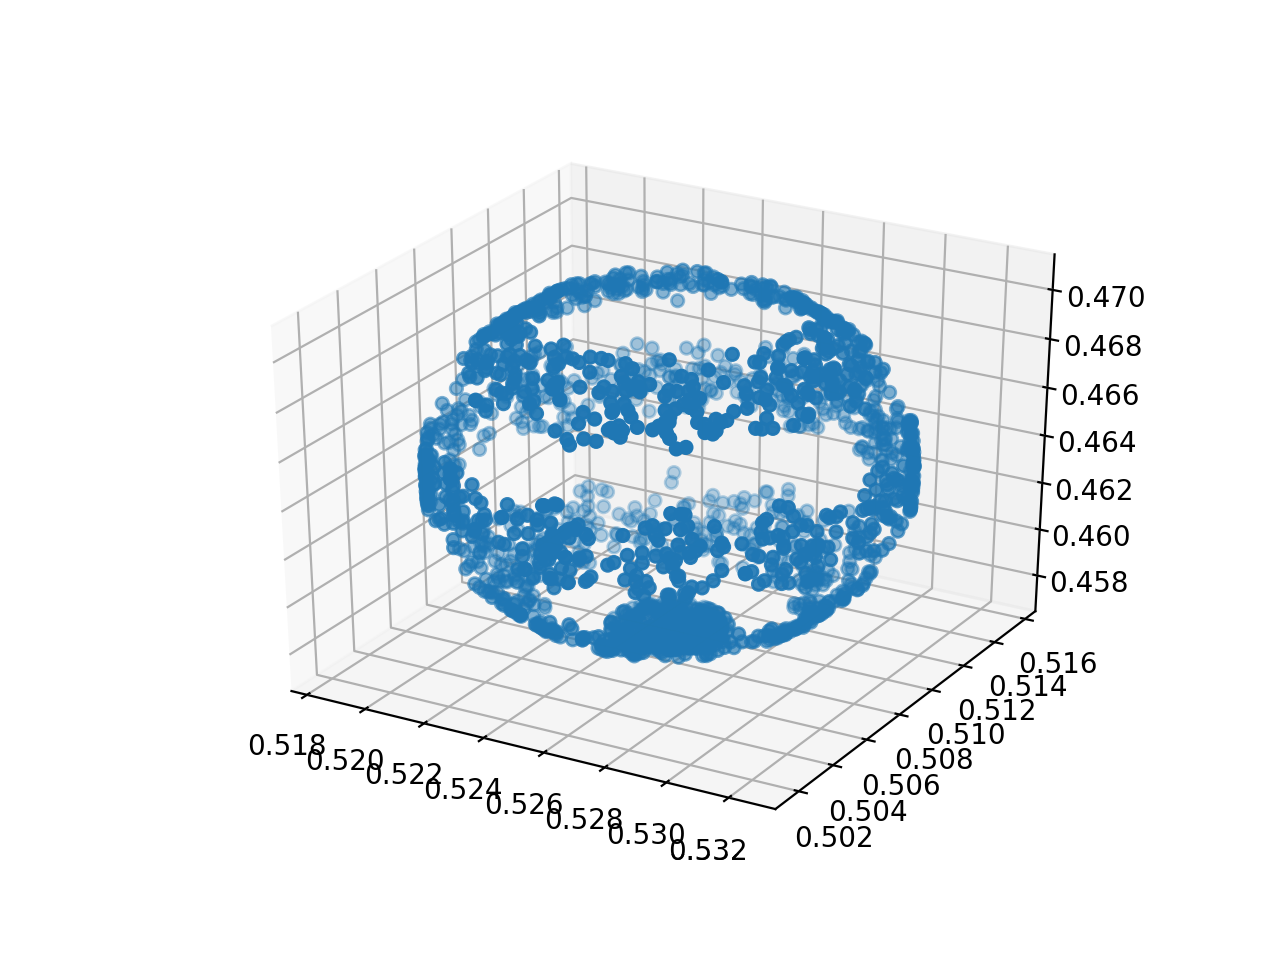

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig0 = plt.figure()
ax0 = fig0.add_subplot(111, projection='3d')
ax0.scatter(x_1, y_1, z_1)



## Endpoints

In [6]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(x_2,y_2,z_2)

## Startpoint and Endpoint Lines (Sightlines) 

<IPython.core.display.Javascript object>


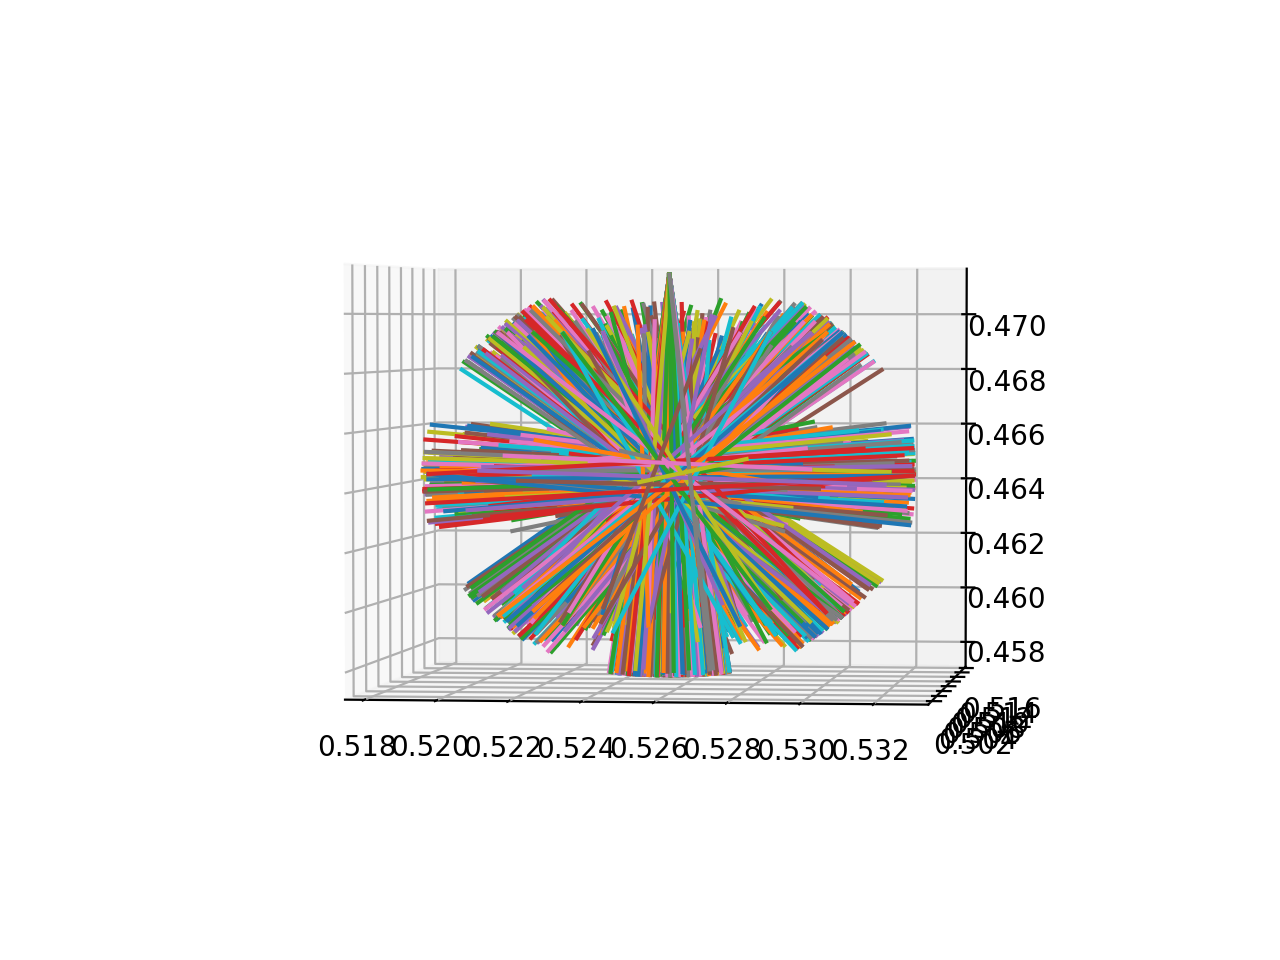

In [7]:
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111, projection='3d')
for i in range(len(x_1) - 1):
    x = [x_1[i], x_2[i]]
    y = [y_1[i], y_2[i]]
    z = [z_1[i], z_2[i]]
    ax2.plot(x, y, z)
plt.savefig('Test_Fig')

## Midpoints

<IPython.core.display.Javascript object>


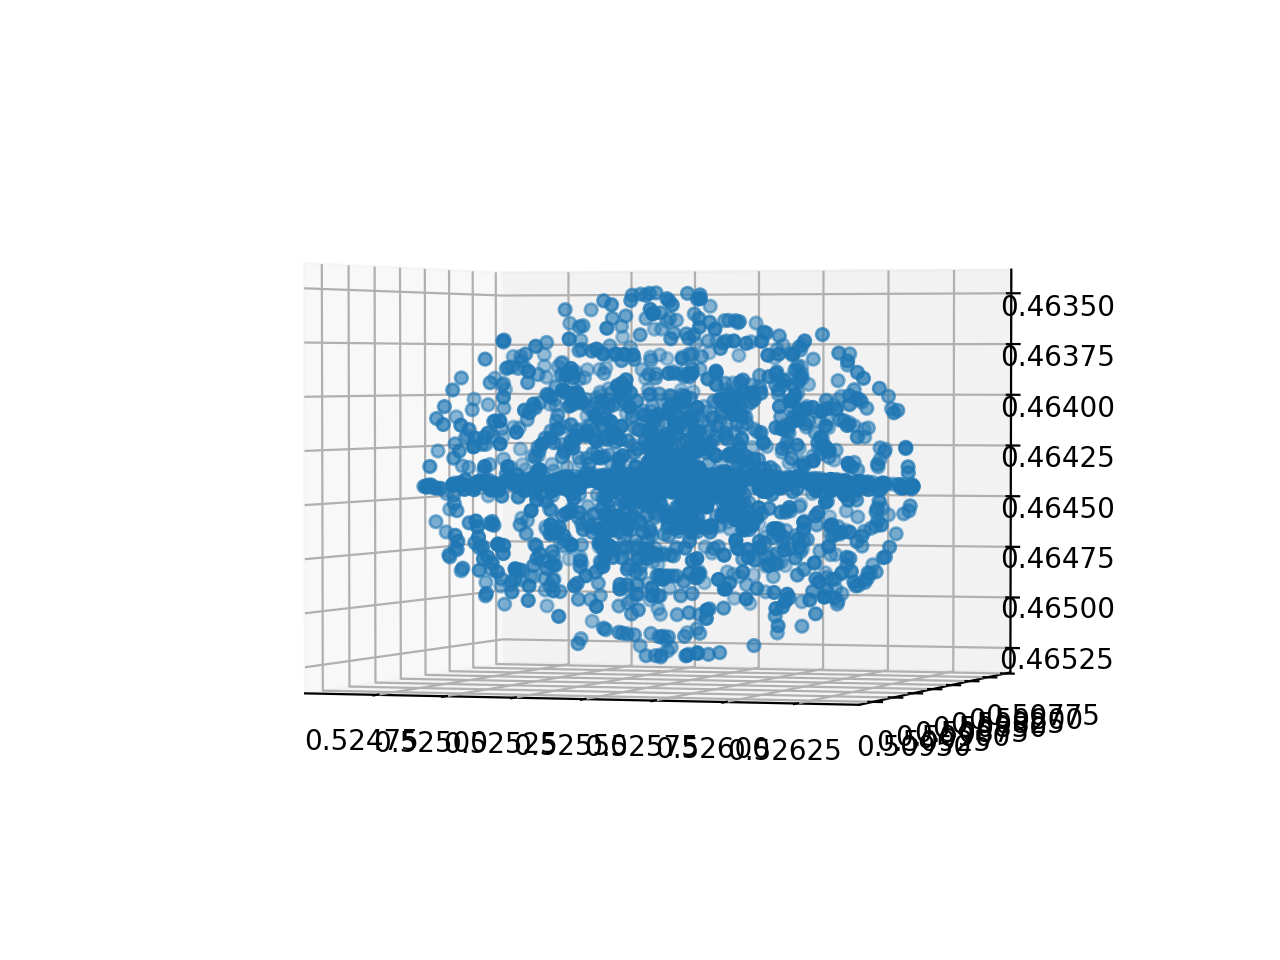

[[0.52547629 0.52623583 0.52568586 ... 0.52599255 0.52622667 0.52543083]
 [0.50854148 0.50879259 0.50921025 ... 0.50924148 0.50862709 0.50812267]
 [0.46452303 0.46442016 0.46440155 ... 0.46442016 0.46454753 0.46492207]]


In [8]:
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111, projection='3d')
print(midpoints)
ax3.scatter(midpoints[0], midpoints[1], midpoints[2])

#inner sphere specifics
r = 12.5
convert = q.ds.length_unit.in_units('kpc').value
r/=convert
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

#ax3.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)